In [202]:
t1 <- Sys.time()

# Purpose
The purpose of this study is to predict a HbA1c value given knowledge of the lagged HMA state, the twice-lagged HMA state, and however many lagged HbA1c values optimise the fit of the model.

# Considerations
For explainability, I restrict myself to regression and similar approaches. The observations of HbA1c and HMA state are repeated within patients, so the obvious first option is a Generalised Linear Mixed Model (GLMM).

GLMMs permit us to make use of the repeated observations. This wouldn't usually be permissible because repeated observations have a dependency between them (i.e. they are all from the same person), which violates an assumption of regression models fit using the ordinary-least squares procedure. A GLMM approach to our intended prediction model would, at the very least, include a random intercept for `person_id`, which would have the effect of nesting patients' repeated observations with a patient clustering variable. (I would refrain from including a random slope for repeat index because I have no sensible assumption about the form of the time-dependent trend in HbA1c.)

The problem with GLMMs, which makes them inappropriate for my task, is that the patient clustering variable that is used when fitting the model will be required for all future predictions. That is to say, GLMMs are resticted to making predictions about the patient records that informed the model, only. Such a model would be incapable of making predictions for other patient records, which is the intended use of the prediction model.

An alternative approach is to use Generalised Estimating Equations (GEEs). GEEs will provide the same predictions as an equivalent GLMM, if there are no missing data, the same covariance structure is assumed, and an identity link function is used (note: the standard errors will be different, though). Crucially, the GEE handles the dependency between repeated observations differently to GLMMs such that a patient clustering variable is not required. This means that predictions can be made for never-before-observed patient records, so long as the 'predictors' are available for input. This is accomplished by encoding the dependency between repeated observations in the covariance matrix, rather than encoding it using an additional variable (i.e. the patient clustering variable used in the GLMM).

### Differences in interpretation.
GLMMs and GEEs are different approaches to summarising the sample data. Thus, the meaning of their coefficeints and predictions differ. The GEE provides a population-averaged prediction, conditional on the 'predictors'. In contrast, the GLMM would have provided a cluster-specific prediction, conditional on the 'predictors' and the value of the clustering variable. This is why the standard errors for the coefficients are different between the approaches.

### Why a GLMM will be helpful even though we won't use it.
Even though we can't use a GLMM for the ultimate prediction model, I will use a GLMM to choose which 'predictors' to include. The rationale is that GEEs are not models so they don't have any goodness-of-fit statistics to tell me when the data are good fit to the model. But I can calculate goodness-of-fit statistics for GLMMs.

I will use Bayesian Information Criteria (BIC) on a GLMM to determine the best set of 'predictors' from my shortlist. I will then use a GEE with these 'predictors' to produce my prediction model.

## A note on missing data: a caveat for the preditions.
My intention is to used lagged values of the variate and the HMA-state variable as predictors. This means that the earlier observations in a patient's sequence will not have a value. For example, a patient's first observation cannot have a lagged observation because it is the first.

Unfortunately, I cannot include missing observations to inform the 'model' because they are meaningfully missing. The consequence is that the first few obsverations in every patient's record will be excluded. There are some patient records with only a few observations, so these patients' information with be excluded entirely.

Thus, the prediction model is only valid for patient records that have at least one more observation than the number of lags I include in the 'model'.

# Get requisite packages.

In [203]:
# Get requisite packages.
if( !"pacman" %in% installed.packages() )
{
  install.packages( "pacman" )
  libray( pacman )
}
pacman::p_load(
    emmeans
    ,tidyverse
    ,geepack
    ,lme4
)

# Generate the cohort.

In [204]:
source('RESHAPE_cohort_generator.r')

# Format the data.

In [205]:
source('RESHAPE_format_the_data.r')

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


# Finalise dataset.

In [206]:
dataset <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::distinct( person_id, HbA1c, HMA) %>%
    dplyr::filter( !is.na( HbA1c ) ) %>%
    dplyr::mutate( HMA = HMA %>% droplevels() ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( rn = row_number() ) %>%
    dplyr::ungroup() %>%
    dplyr::arrange( person_id, rn ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        lagged_HbA1c = lag( HbA1c )
        ,lagged_lagged_HbA1c = lag( HbA1c, 2L )
        ,HMA_lag1 = lag( HMA )
        ,HMA_lag2 = lag( HMA, 2L )
        ,HMA_lag3 = lag( HMA, 3L )
        ,HMA_lag4 = lag( HMA, 4L )
        ,HMA_lag5 = lag( HMA, 5L )
        ,HMA_lag6 = lag( HMA, 6L )
        ,HMA_lag7 = lag( HMA, 7L )
    ) %>%
    dplyr::ungroup()

# Check for autocorrelation.
I first want to assess how many lagged observations of the variate (i.e. HbA1c) I should include as 'predictors'. To do this, I assess the autocorrelation of the variate. I will include as many lags of the variate as there are lags that surpass the threshold in the autocorrelation-function plot.

The ACF ( <u>a</u>uto<u>c</u>orrelation <u>f</u>unction ) is the covariance of two observations either end of a sliding window in a sequence, standardised to the (assumed to be) stationary variance of all observations. The value cannot be greater than +1 or -1, but the sign of the value indicates positive or negative autocorrelation.

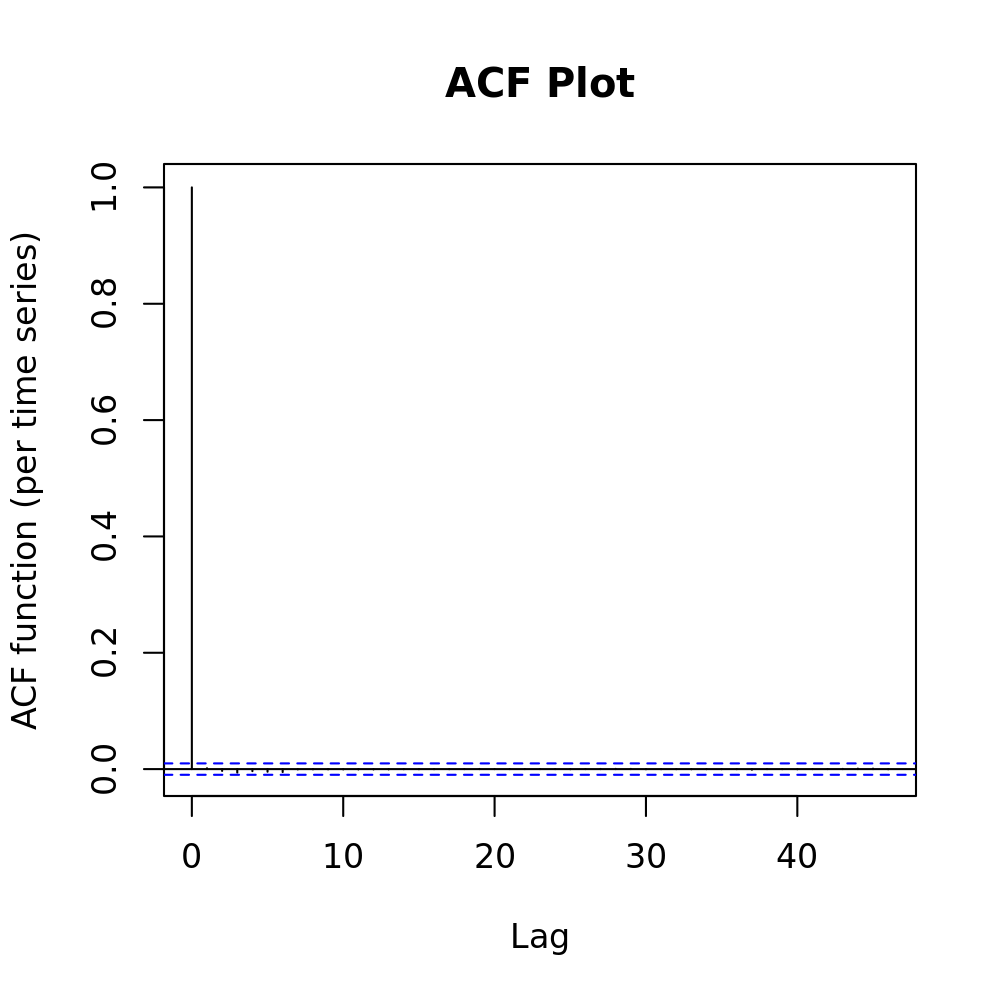

In [207]:
options( repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200 )

lme4::lmer(
    HbA1c ~ ( 1 | person_id)
     ,data = dataset
) %>%
itsadug::acf_resid( main = "ACF Plot" ) 

The ACF plot shows no effective autocorrelation in the HbA1c values, when we nest repeated observations within `person_id`.

The first vertical line the reference value of 1 for an observation correlating with itself. The thresholds indicated by the two dashed blue lines are the 95% confidence intervals for zero autocorrelation. Any non-zero value for the autocorrelation within these thresholds is compatible with the true value being zero. 

I conclude that there is no need to include any lags of variate (i.e. HbA1c) in the model.

# Fit generalised linear mixed model.
Next, I fit several GLMMs to determine the best set of 'predictors' from my shortlist. I will assess lagged values of HbA1c even though my assessment of autocorrelation showed that lagged values of HbA1c are not associated with current values.

I will only assess up to twice-lagged variables because:
1. discussions with a GP colleague (CB) suggested that one typically wouldn't review more than two testing instances prior when making a decision about what to do next because the relevance of test results and patients' health states are transient.
2. as mentioned earlier, the greater the number of lags, the greater the number of observations that are excluded, which also leads to excluding a greater number of patients with a count of records fewer than the number of lags.

In [208]:
GLMM_intercept_only <-
    lme4::lmer(
        HbA1c ~  ( 1 | person_id )
        ,data = dataset
    )
GLMM_oneHMA <-
    lme4::lmer(
        HbA1c ~ HMA_lag1 + ( 1 | person_id )
        ,data = dataset
    )
GLMM_twoHMA <-
    lme4::lmer(
        HbA1c ~ HMA_lag1 + HMA_lag2 + ( 1 | person_id )
        ,data = dataset
    )
GLMM_twoHMA_oneHbA1c <-
    lme4::lmer(
        HbA1c ~ HMA_lag1 + HMA_lag2 + lagged_HbA1c + ( 1 | person_id )
        ,data = dataset
    )
GLMM_twoHMA_twoHbA1c <-
    lme4::lmer(
        HbA1c ~ HMA_lag1 + HMA_lag2 + lagged_HbA1c + lagged_lagged_HbA1c + ( 1 | person_id )
        ,data = dataset
    )

data.frame(
    model = c(
        "GLMM_intercept_only"
        ,"GLMM_oneHMA"
        ,"GLMM_twoHMA"
        ,"GLMM_twoHMA_oneHbA1c"
        ,"GLMM_twoHMA_twoHbA1c"
    )
    ,BIC = c(
        BIC( GLMM_intercept_only )
        ,BIC( GLMM_oneHMA )
        ,BIC( GLMM_twoHMA )
        ,BIC( GLMM_twoHMA_oneHbA1c )
        ,BIC( GLMM_twoHMA_twoHbA1c )
        )
    )

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



model,BIC
<chr>,<dbl>
GLMM_intercept_only,619156.1
GLMM_oneHMA,544517.4
GLMM_twoHMA,475432.2
GLMM_twoHMA_oneHbA1c,475449.6
GLMM_twoHMA_twoHbA1c,475467.0


I use the Baysian Information Criteria ( BIC ) as the model fit statistic. The results table above shows that including the HMA state as a covariate improves the fit of the model. The fit is further improved by adding the twice-lagged HMA state.

Including the once-lagged and twice-lagged HbA1c value worsened the model fit, which supports the finding from the assessment of autocorrelation. That is to say, including lagged HbA1c values probably did nothing to improve the fit of the model but was penalised for unnecessary complication of the model.

I conclude that the 'prediction' 'model' should only include the `HMA_lag1` and `HMA_lag2` covariates.

# Fit generalised estimating equations.
Finally, I estimate a GEE using `HMA_lag1` and `HMA_lag2` as covariates / 'predictors'. I select an exchangeable covariance structure blocked by `person_id`, which means that I nest observations within `person_id` and each nested observation has the same association with any other (i.e. there is no assumed decay of association that might arise from time ordering, within a patient's repeated observations). I chose the exchangeable covariance structure because the previous assessment of autocorrelation suggested that there was no substantial time-ordered dependency between observations of the variate (i.e. HbA1c).

After estimating the GEE, I check the psuedo-residuals to check the assumption of conditional constant variance and serial correlation. I also plot a calibration plot to check how well matched the observed and predicted values are.

In [209]:
GEE_twoHMA <-
    geepack::geeglm(
        HbA1c ~ HMA_lag1 + HMA_lag2
        ,id = person_id
        ,corstr = "exchangeable"
        ,data = dataset %>% tidyr::drop_na()
    )

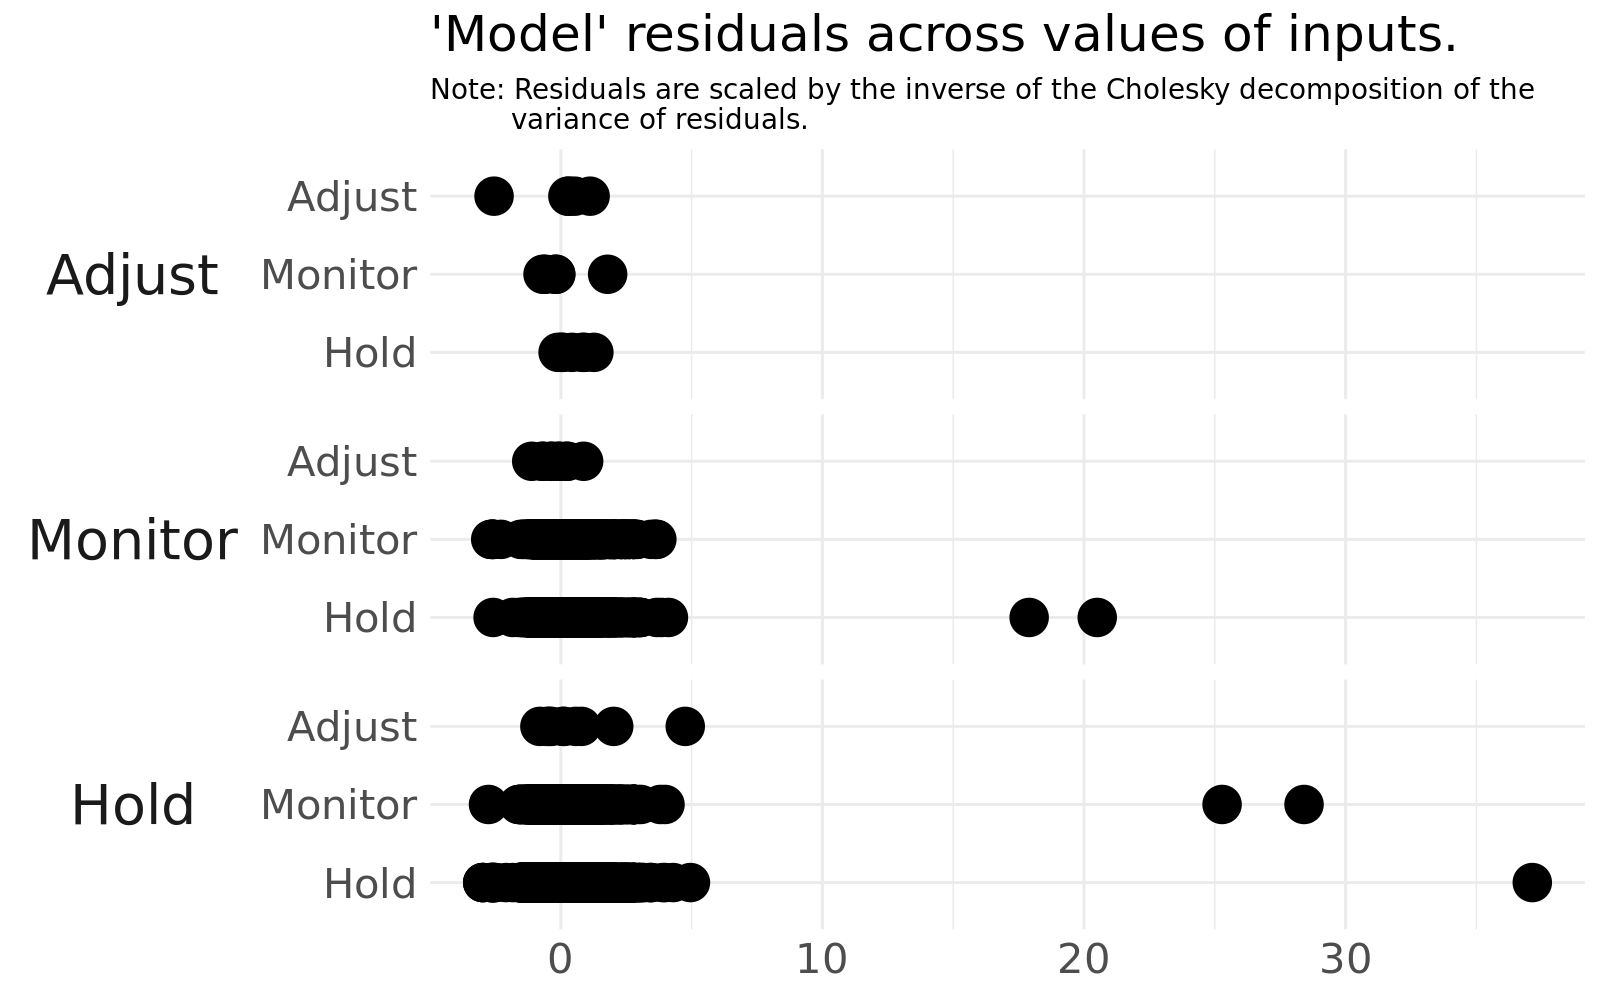

In [210]:
# Calculate the residuals.
# ## source: page 156, https://courses.washington.edu/b571/lectures/set3.pdf
calibration_df <-
    dataset %>%
    tidyr::drop_na() %>%
    dplyr::select( HbA1c ) %>%
    `colnames<-`( "obs" ) %>%
    dplyr::bind_cols( pred = predict( GEE_twoHMA ) ) %>%
    dplyr::mutate( diffs = obs - pred )

choleskey_scalar <-
    calibration_df %>%
    dplyr::select( diffs ) %>%
    var() %>%
    chol() %>%
    MASS::ginv()

calibration_df <-
    calibration_df %>%
    dplyr::mutate( chol_diffs = diffs * choleskey_scalar[1])


# Make residuals plot.
options( repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200 )

plot_df <-
calibration_df %>%
    dplyr::bind_cols( dataset %>% tidyr::drop_na() )

plot_residuals <-
plot_df %>%
ggplot() +
geom_point(
    aes( x = HMA_lag2, y = chol_diffs )
    ,size = 6
) +
labs(
    title = "'Model' residuals across values of inputs."
    ,subtitle = "Note: Residuals are scaled by the inverse of the Cholesky decomposition of the\n         variance of residuals."
) +
facet_grid( rows = vars( fct_rev( HMA_lag1 ) ), switch = "both", scales = "free_x", space = "free_x") +
coord_flip() +
theme_minimal() +
theme(
    title = element_text( size = 15 )
    ,strip.placement = "outside"
    ,strip.text.y.left = element_text( size = 20, angle = 0 )
    ,axis.title = element_blank()
    ,plot.subtitle = element_text( size = 10 )
    ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
    ,legend.title = element_blank()
    ,legend.position = 'none'
    ,axis.text = element_text( size = 15 )
)

plot_residuals

Outliers are clearly seen on the far right of the residual plot. These will need to be removed.

It is difficult to see any pattern when outliers are included so the next plot zooms in on values less than 10.

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”


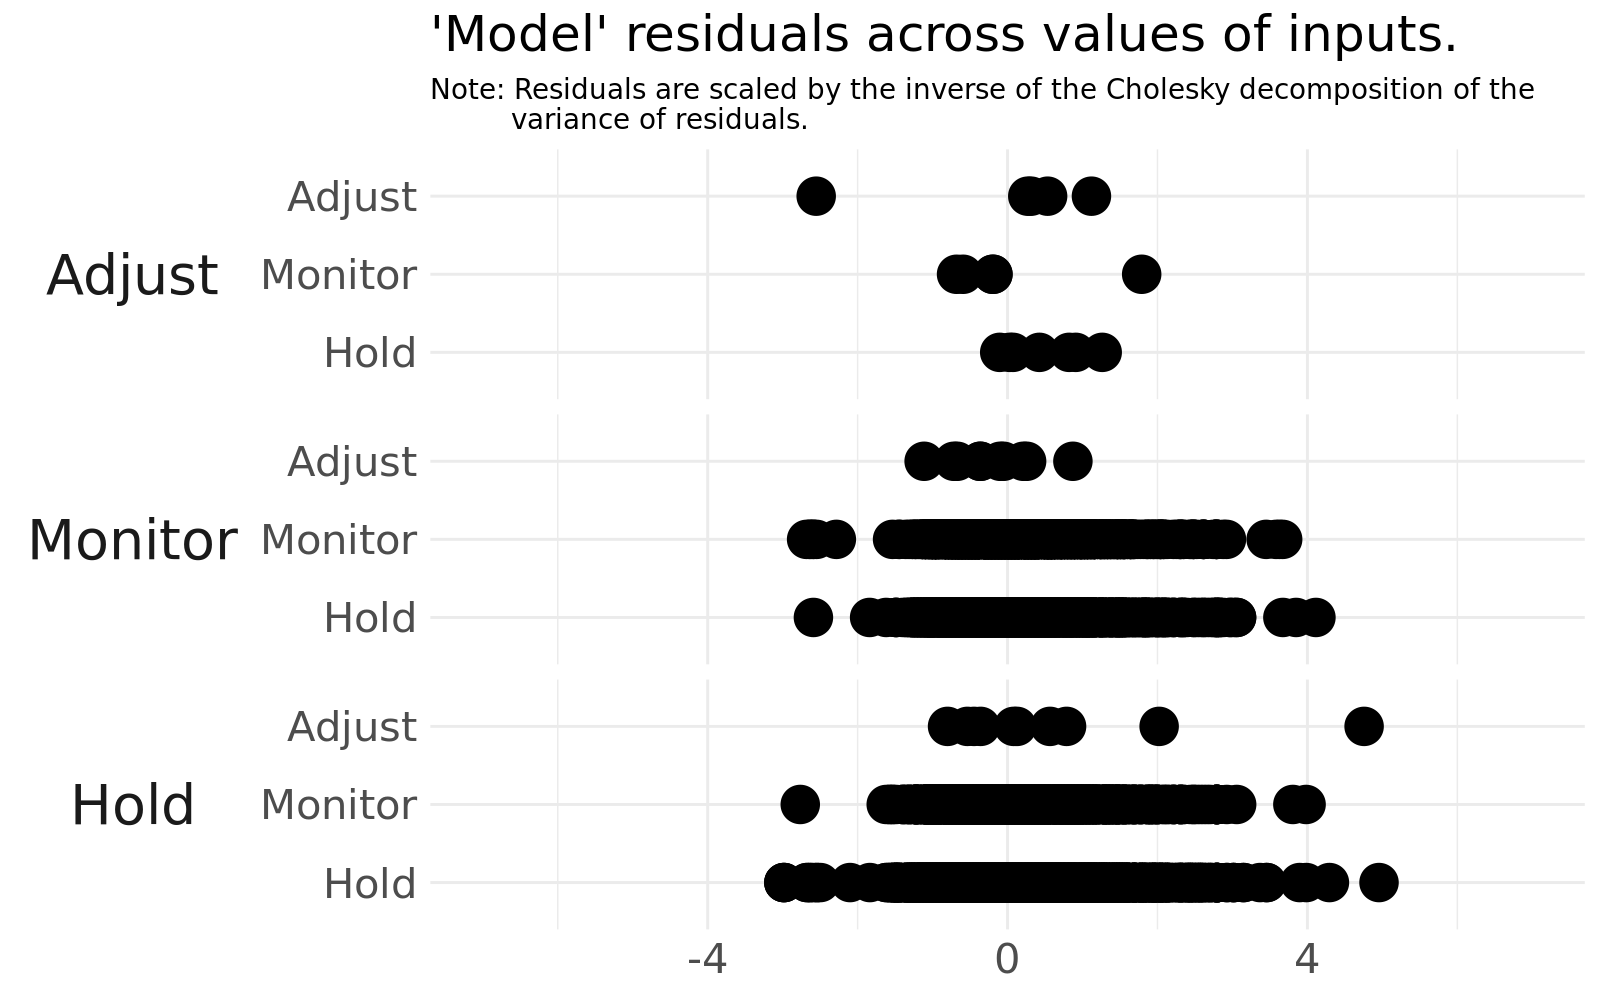

In [211]:
plot_residuals + ylim(-7, 7)

One could argue that there is a a pattern of a narrowing range for scenarios where the once-lagged HMA state is Adjust, but this is does not hold true for the set of scenarios where Adjust is the twice-lagged state. However, the narrowing associated with the once-lagged Adjust is also seen at the higher level when comparing the sets of once-lagged states nested with the twice-lagged states. In other words, the scenarios where the twice-lagged state is Adjust shows a narrower range of residuals, similar to the scenarios where the Adjust state follows a Monitor and Hold state.

In summary, there seems to be a systematic bias toward more-accurate estimations of means following Adjust states, but it is not clear whether these HbA1c values are truly less variable or whether the GEE is better at estimating them. Given that we know that the Adjust states are observed vastly-less often than the other states, it is not likely that the GEE is better at estimating them by virtue of a wealth of information in our sample. Thus, I hypothesise that the range of HbA1c values following an Adjust state have a smaller range.

Below I show the range of HbA1c values stratified by the twice-lagged and once-lagged HMA states. It shows:
1. HbA1c values once-lagged by Adjust have a smaller range than those once-lagged by the other HMA states, except for the Adjust-Adjust observations.
2. HbA1c values twice-lagged by Adjust have a smaller range than those twice-lagged by the other HMA states.

In conclusion, I don't think that the systematic bias seen in the residual plot is an issue with 'model' specification. Rather it is a representation of the selectively-narrower ranges in sample observed.

In [212]:
dataset %>%
tidyr::drop_na() %>%
dplyr::group_by( HMA_lag2, HMA_lag1 ) %>%
dplyr::summarise( range = max( HbA1c ) - min( HbA1c ) ) %>%
dplyr::ungroup()

`summarise()` has grouped output by 'HMA_lag2'. You can override using the
`.groups` argument.


HMA_lag2,HMA_lag1,range
<fct>,<fct>,<dbl>
Hold,Hold,909.74635
Hold,Monitor,523.69585
Hold,Adjust,31.00000
Monitor,Hold,706.93145
Monitor,Monitor,144.00000
Monitor,Adjust,56.00000
Adjust,Hold,126.00000
Adjust,Monitor,45.00000
Adjust,Adjust,83.25715


Next, I view the caliration plot. The intercept and slope of the calibration model are shown below. Perfect calibration would have an intercept of 0 and a slope of 1.

(Intercept)          obs 
6.667619e+01 3.521996e-04

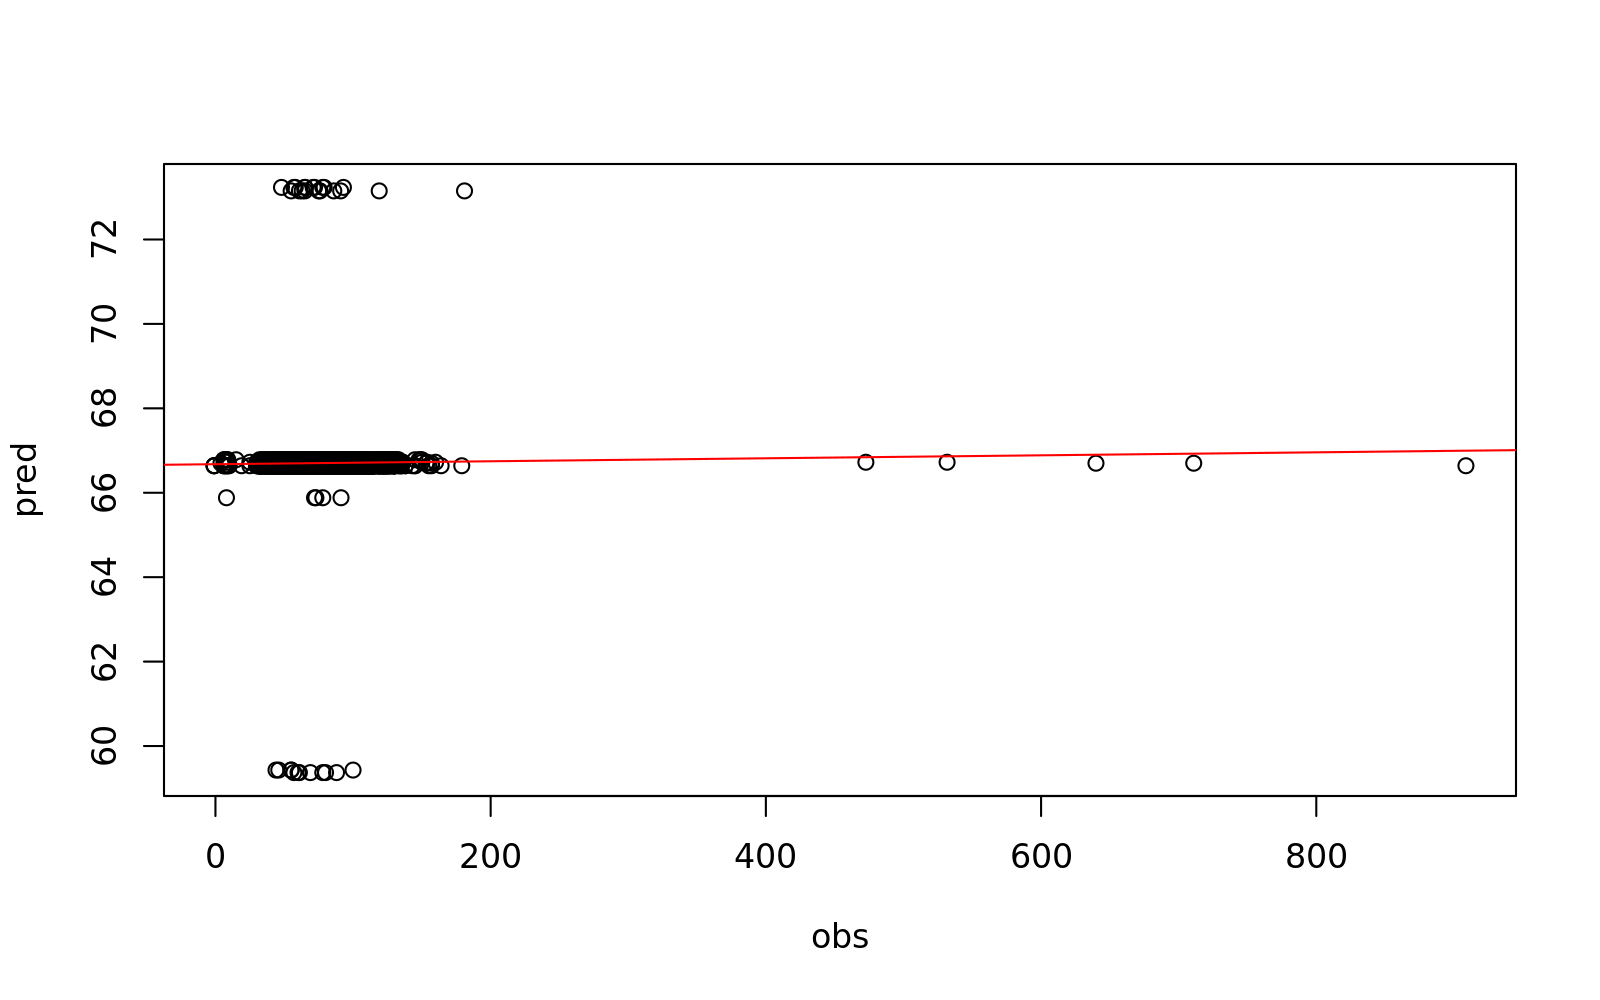

In [213]:
# Make a calibration plot to see how well the observed and predicted values match.
calibration_mod <- lm( pred ~ obs, data = calibration_df )
coef( calibration_mod )
plot( calibration_df %>% dplyr::select( obs, pred ) ) 
abline( calibration_mod, col = 'red' ) 

It is clear from the calibration plot that:
1. the observed data include substanital outliers, and
2. the predicted values for HbA1c discontinually cluster around only three values.

The outliers are an expected part of routinely-collected healthcare data but were not known until now. I must find a way to identify and exclude these. It is worth noting that the estimated means from the GEE (i.e. the 'predictions') are robust to these outliers, as one would expected from the arithmetic mean. In other work, I compared predictions from a GLMM specified with the same covariates but with a random intercept for `person_id`, and the predictions matched the samples' outliers rather than generalising.

The discontinuity of 'predicted' values is not surprising given that the GEE estimates means conditional on the covariates, and we specified categorical covariates. Therefore, the 'predictions' are, sensibly, the estimated means for cohort subgroups, with some variation. The fact that there are only three clusters / levels of estimated means is not necessarily expected, given that the two covariates had three levels each, which could have resulted in nine possible distinct estimated means. This finding is insightful because it suggests that sequences of HMA states don't exponential explode into many forking. Rather, there might be three basins of attraction, when it comes to HbA1c values.

# Predictions from GEE.
I will only retrieve 'predictions' for the GEE because the GLMM requires `person_id` as a variable, which limits it to providing predictions for the records in the sample data, only.

Rather than provide the GEE as a 'prediction' 'model' that needs computing for every use, I can provide a simple look-up table because there are only nine possible combinations of the input variables. I round the 'predicted' values to the nearest whole number, in the table below.

In [214]:
(
GEE_predictions_lookup_table <-
    emmeans::emmeans(GEE_twoHMA, ~HMA_lag1 + HMA_lag2) %>%
    as.data.frame() %>%
    dplyr::select( -df ) %>%
    dplyr::arrange( HMA_lag1, HMA_lag2 )
)

HMA_lag1,HMA_lag2,emmean,SE,asymp.LCL,asymp.UCL
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Hold,Hold,66.63978,0.431748,65.79357,67.48599
Hold,Monitor,66.69954,0.428506,65.85969,67.53940
Hold,Adjust,73.15084,4.138562,65.03941,81.26228
Monitor,Hold,66.72249,0.375651,65.98623,67.45875
Monitor,Monitor,66.78225,0.513232,65.77634,67.78817
Monitor,Adjust,73.23355,4.114761,65.16877,81.29834
Adjust,Hold,59.37049,4.228166,51.08344,67.65755
Adjust,Monitor,59.43025,4.240316,51.11939,67.74112
Adjust,Adjust,65.88155,3.640500,58.74631,73.01680


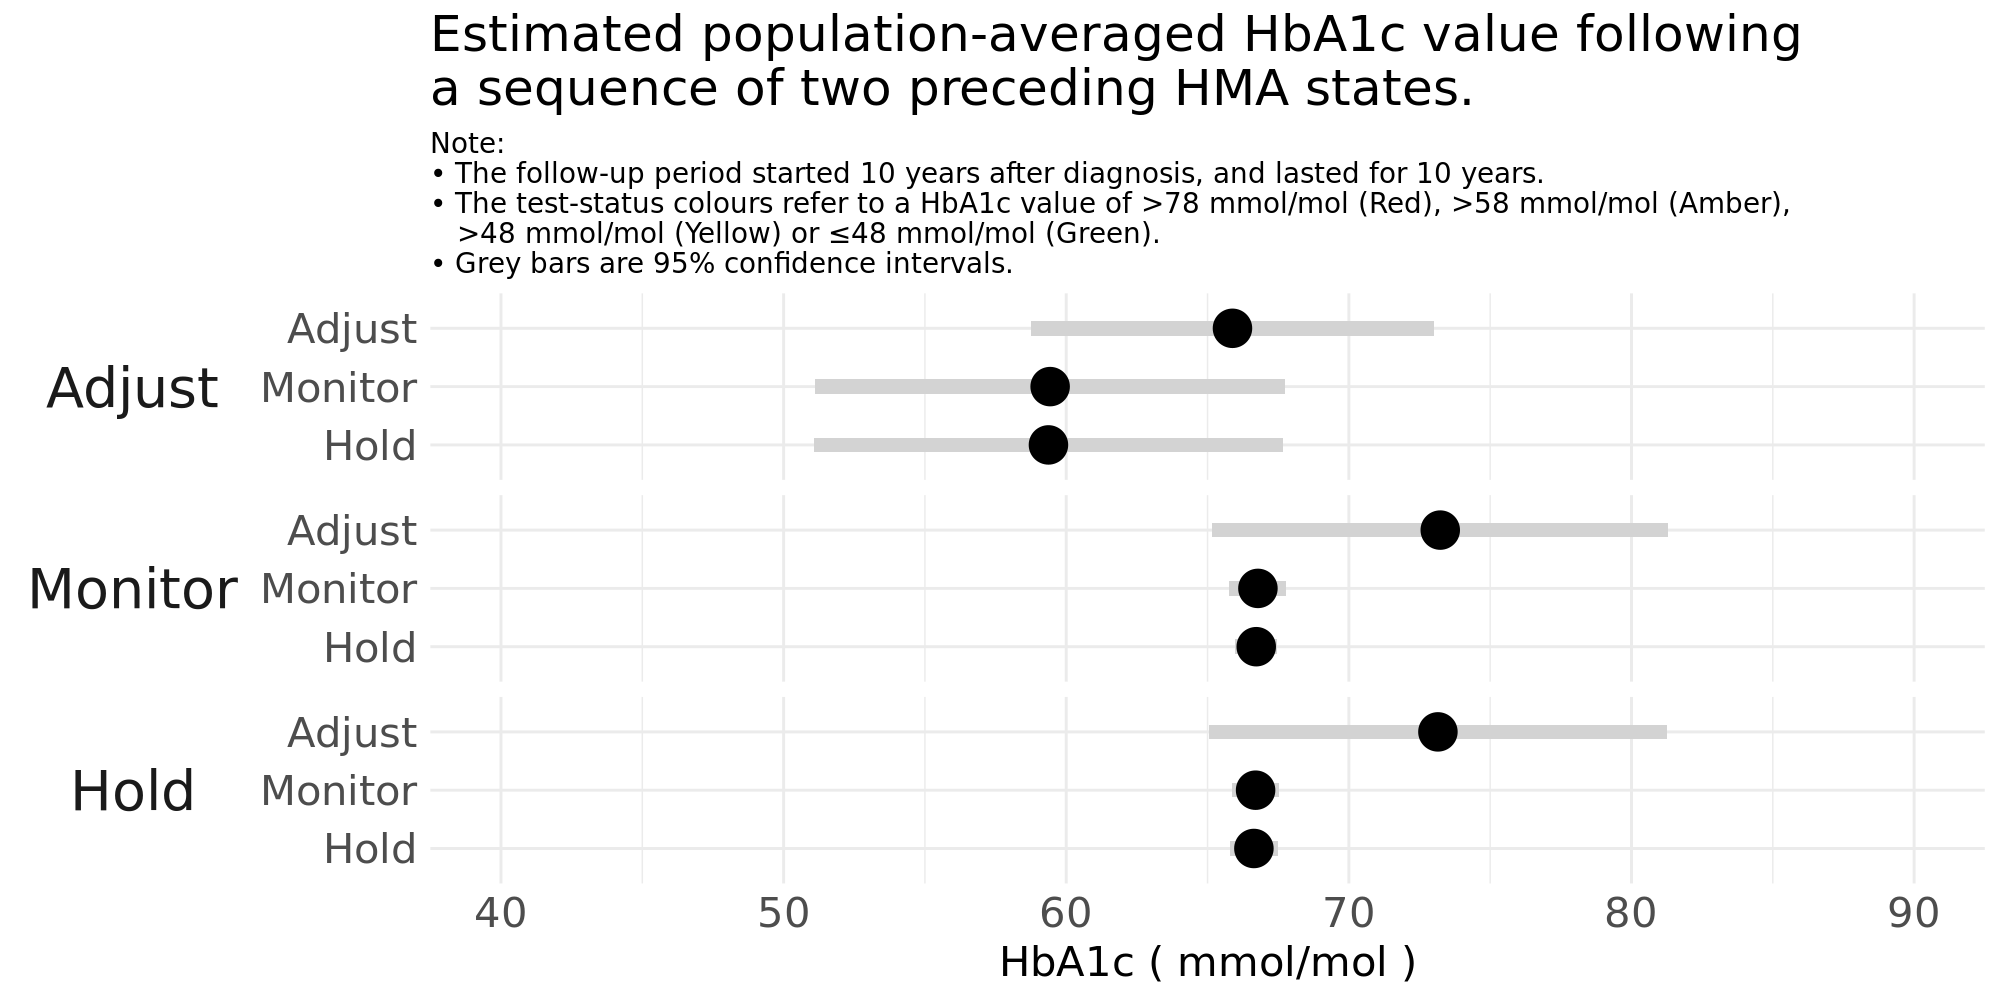

In [215]:
options( repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200 )

background_colours <-
    data.frame(
            RAYG = df_event_factor %>%
                    dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>%
                    dplyr::select( event_colours_order ) %>%
                    droplevels() %>%
                    dplyr::pull()
            ,min_val = c( 70, 58, 48, -Inf )
            ,max_val = c( Inf, 70, 58, 48 )
        )

plot_GEE_estimate_means <-
GEE_predictions_lookup_table %>%
ggplot() +
#geom_rect(
#    data = background_colours
#    ,aes(
#        fill = RAYG
#        ,xmin = -Inf
#        ,xmax = Inf
#        ,ymin = min_val
#        ,ymax = max_val
#    )
#    ,alpha = 0.5
#) +
geom_tile(
    aes( x = HMA_lag2, y = emmean, width = 0.25, height = 2 * SE * qt( 0.975, df = nrow( dataset ) - 1 ) )
    ,fill = "lightgrey"
) +
geom_point(
    aes( x = HMA_lag2, y = emmean )
    ,size = 6
) +
labs(
    title = "Estimated population-averaged HbA1c value following\na sequence of two preceding HMA states."
    ,subtitle = paste0(
        "Note: \n"
        ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis, and lasted for ", followup_duration_in_years," years.\n")
        ,"\u2022 The test-status colours refer to a HbA1c value of >78 mmol/mol (Red), >58 mmol/mol (Amber),\n   >48 mmol/mol (Yellow) or \u226448 mmol/mol (Green).\n"
        ,"\u2022 Grey bars are 95% confidence intervals."
        )
    ,y = "HbA1c ( mmol/mol )"
) +
ylim( 40, 90 ) +
facet_grid( rows = vars( fct_rev( HMA_lag1 ) ), switch = "both", scales = "free_x", space = "free_x") +
coord_flip() +
theme_minimal() +
theme(
    title = element_text( size = 15 )
    ,strip.placement = "outside"
    ,strip.text.y.left = element_text( size = 20, angle = 0 )
    ,axis.title.y = element_blank()
    ,plot.subtitle = element_text( size = 10 )
    ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
    ,legend.title = element_blank()
    ,legend.position = 'none'
    ,axis.text = element_text( size = 15 )
)


plot_GEE_estimate_means

# Results.
I make the following observations:
1. Monitor-state means are indistinguishable from Hold-state means.
2. Following a Hold or Monitor state, an Adjust state is associated with a higher mean HbA1c.
3. Means twice-lagged by an Adjust state are lower but less certain than means twice-lagged by either other state.
4. Confidence intervals are wide for the Adjust-state means, specifically.

# Discussion
It is imporant to understand the context of these data, when interpreting the results:
1. This cohort of healthcare records are for those patients whose diagnosis was before 2000.
2. This cohort of healthcare records are those 10 years after the patient's diagnosis.
3. The proportion of HbA1c values in these records are predominantly Red (>78 mmol/mol) or Yellow (>48 mmol/mol), followed by Amber (>58 mmol/mol), and relatively few Green ($\le$48 mmol/mol).
4. The method I've used considers all successive 3-event sequences within and across patients - i.e. 1 = HMA state, 2 = HMA state, 3 = HbA1c value - so patients with long sequences will contribute more to the calculated means than those with short sequences because they contain more 3-event subsequences.
5. The patients with longer sequences are more stable in their HMA states so the scenarios with repeated states (e.g. Hold-Hold or Monitor-Monitor) are more common and, thus, weighted more in the calculated means.
6. The analysis does not explicitly account for prior HbA1c values so we cannot suppose to what extent the HMA states are responses to changes (or stability) of HbA1c values.
7. The count of patients with records of an Adjust state has a half life of one inter-test interval. This means that there are almost no instances of the Adjust state after the fifth test event.

## Monitor-state means are indistinguishable from Hold-state means.
Monitor-state means are indistinguishable from Hold-state means, whether means are grouped by the twice-lagged state or the once-lagged state. Given that the Monitor state is defined by more frequent testing, one might conclude that the additional burden of this testing does not confer improvement in subsequent HbA1c and is unnecessary. However, the greater frequency of testing might have provided peace of mind, which is an unmeasured part of the sociobiology of healthcare.

## Following a Hold or Monitor state, an Adjust state is associated with a higher mean HbA1c.
Following a Hold or Monitor state, an Adjust state is associated with a higher mean subsequent HbA1c. It is important to note that our analysis does not tell us what the preceding HbA1c values are, so it is not clear whether the Adjust state is a response to an already-larger HbA1c value or is a cause of. The high observed HbA1c could be a continuation of a high HbA1c observed when in the previous, non-Adjust states and the Adjust state is an as-yet-ineffective attempt to attenuate it. Alternateively, an adjustment intended to attenunate HbA1c that was not satisfactorily low could have made things worse.

## Means twice-lagged by an Adjust state are lower but less certain than means twice-lagged by either other state.
Means twice-lagged by an Adjust state are lower but less certain than means twice-lagged by either other state. The sample mean for the Adjust-Adjust scenario is similar to the lower HbA1c means found in the Hold and Monitor scenarios. Even if we consider the width of the 95% confidence intervals, these lower means for the Adjust twice-lagged Adjust scenario are unexpected given my proposed justification for higher Adjust means that follow Hold and Monitor states.

To explain this finding, it might be insightful to note the context that the count of patients with records of an Adjust state has a half life of one inter-test interval. This means that the Adjust states were only observed early in patients' record sequences, which is when we would expect HbA1c values to be more volatile (i.e. compared to even later in the patient's long-term care). It might be the case that the patients for whom we have longer sequences are those who are passed their volatile stage and settled into HbA1c values that are, unfortunately, further from what would be desirable. This is supported by the context that desirable HbA1c values ( $\le$48 mmol/mol ) make up the smallest proportion of observations.

An alternative (but not likely) explanation is that there is a delay in the effect of an adjustment. That is to say, it takes two observation periods for an adjustment to have an attentuation effect. All scenarios of HbA1c that are only one observation period away from an adjustment do not show any benefit. In summary, 

# Confidence intervals are wide for the Adjust-state means, specifically.
A simple plot of the estimated means and their 95% confidence intervals shows that all of the confidence intervals overlap. This implies that the true value of the mean could be the same (around 67 mmol/mol) for all scenarios. However, the substantially-wider intervals found in any scenario that included the 'Adjust' state is likely due to the relatively-very small number of observations of the 'Adjust' state. With so few observations of scenarios involving the 'Adjust' state, we don't have much confidence that those sample observations are representative, so our interval must be set wide to acknowledge the uncertainty in our inference about the true population mean. Were the confidence intervals for scenarios involving the 'Adjust' state similar to those for the other scenarios, we could infer markedly worse mean HbA1c for scenarios with an Adjust value in the once-lagged state.



In [216]:
Sys.time() - t1

Time difference of 49.23451 secs

# Fit generalised linear mixed model.
Next, I fit several GLMMs to determine the best set of 'predictors' from my shortlist. I will assess lagged values of HbA1c even though my assessment of autocorrelation showed that lagged values of HbA1c are not associated with current values.

I use the Baysian Information Criteria ( BIC ) as the model fit statistic. The results table above shows that including the HMA state as a covariate improves the fit of the model. The fit is further improved by adding the twice-lagged HMA state.

Including a the lagged and twice-lagged HbA1c value worsened the model fit. This supports the finding from the assessment of autocorrelation.

I conclude that the ultimate prediction model should only include the `HMA_lag1` and `HMA_lag2` covariates.

# Fit generalised estimating equations.
Finally, I estimate a GEE using `HMA_lag1` and `HMA_lag2` as covariates / 'predictors'. I select an exchangeable covariance structure blocked by `person_id`, which means that I nest observations within `person_id` and each nested observation has the same association with any other (i.e. there is no assumed decay of association that might arise from time ordering). I chose the exchangeable covariance structure because the previous assessment of autocorrelation suggested that there was no substantial time-ordered dependency between observations of the variate (i.e. HbA1c).

In [217]:
GEE_sevenHMA <-
    geepack::geeglm(
        HbA1c ~ HMA_lag1 + HMA_lag2 + HMA_lag3 + HMA_lag4 + HMA_lag5 + HMA_lag6 + HMA_lag7
        ,id = person_id
        ,corstr = "exchangeable"
        ,data = dataset %>% tidyr::drop_na()
    )

# Predictions from GEE.
I will only retrieve predictions for the GEE because the GLMM requires `person_id` as a variable, which limits it to providing predictions for the records in the sample data, only.

Rather than provide the GEE as a prediction model that needs computing for every use, I can provide a simple look-up table because there are only nine possible combinations of the input variables. I round the predicted values to the nearest whole number, in the table below.

In [218]:
(
    GEE_predictions_lookup_table <-
        dataset %>%
        tidyr::drop_na() %>%
        dplyr::distinct( HMA_lag1 ) %>%
        dplyr::pull() %>%
        expand.grid( HMA_lag1 = ., HMA_lag2 = ., HMA_lag3 = ., HMA_lag4 = ., HMA_lag5 = ., HMA_lag6 = ., HMA_lag7 = . ) %>%
        dplyr::arrange( HMA_lag1, HMA_lag2, HMA_lag3, HMA_lag4, HMA_lag5, HMA_lag6, HMA_lag7 ) %>%
        dplyr::mutate( Prediction = predict( GEE_sevenHMA, newdata = . ) %>% round() )
)

HMA_lag1,HMA_lag2,HMA_lag3,HMA_lag4,HMA_lag5,HMA_lag6,HMA_lag7,Prediction
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
Hold,Hold,Hold,Hold,Hold,Hold,Hold,66
Hold,Hold,Hold,Hold,Hold,Hold,Monitor,66
Hold,Hold,Hold,Hold,Hold,Hold,Adjust,68
Hold,Hold,Hold,Hold,Hold,Monitor,Hold,66
Hold,Hold,Hold,Hold,Hold,Monitor,Monitor,67
Hold,Hold,Hold,Hold,Hold,Monitor,Adjust,69
Hold,Hold,Hold,Hold,Hold,Adjust,Hold,67
Hold,Hold,Hold,Hold,Hold,Adjust,Monitor,67
Hold,Hold,Hold,Hold,Hold,Adjust,Adjust,69


The predictions are sensible:
- a Hold state is associated with a lower HbA1c.
- an Adjust is associated with a higher score.
- a Monitor-state prediction is not much distinguishable from the Hold-state prediction.

One might conclude that being in a Monitor state does not confer improvement in subsequent HbA1c. This might be evidence to suggest that the burden of more-frequent testing is unnecessary.